# Load Dataset

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1HBJVV3Bs4qbvWAAFZ1cWJLHxSp6sMfvE
!unzip brain-tumor-classification-mri.zip

Downloading...
From (original): https://drive.google.com/uc?id=1HBJVV3Bs4qbvWAAFZ1cWJLHxSp6sMfvE
From (redirected): https://drive.google.com/uc?id=1HBJVV3Bs4qbvWAAFZ1cWJLHxSp6sMfvE&confirm=t&uuid=ead32730-601d-41cd-9fe7-d276fcfd96ad
To: /content/brain-tumor-classification-mri.zip
100% 91.0M/91.0M [00:02<00:00, 38.4MB/s]
Archive:  brain-tumor-classification-mri.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor

# Import Libraries

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Activation
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm


# Preprocessing

In [ ]:
# Initial settings
image_size = 224
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

X, y = [], []
X_no_tumor = []

# Loading images and labeling
for label in labels:
    folderPath = os.path.join('Training', label)
    for filename in tqdm(os.listdir(folderPath), desc=f"Loading Training Data - {label}"):
        img = cv2.imread(os.path.join(folderPath, filename))
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            if label == "no_tumor":
                X_no_tumor.append(img)
            X.append(img)
            y.append(labels.index(label))


Loading Training Data - pituitary_tumor: 100%|██████████| 827/827 [00:04<00:00, 166.26it/s]


<ipython-input-4-5459f2884f20>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="viridis")


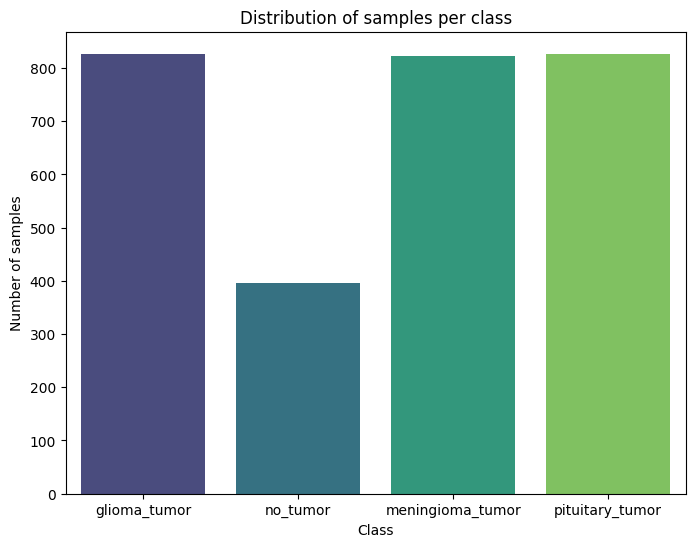

In [ ]:
# Counting the number of samples
label_counts = Counter(y)

# Displaying the number of samples
plt.figure(figsize=(8, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="viridis")

plt.xticks(ticks=range(len(labels)), labels=labels)
plt.ylabel('Number of samples')
plt.xlabel('Class')
plt.title('Distribution of samples per class')
plt.show()


In [ ]:
# Data Augmentation for no_tumor
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

X_no_tumor = np.array(X_no_tumor, dtype=np.float32) / 255.0  # Normalization
y_no_tumor = [labels.index("no_tumor")] * len(X_no_tumor)

# Adding augmented data to Dataset
augmented_images = []
augmented_labels = []

for img in X_no_tumor:
    img = np.expand_dims(img, axis=0)
    aug_iter = datagen.flow(img, batch_size=1)
    for _ in range(1):
        aug_img = next(aug_iter)[0]
        augmented_images.append(aug_img)
        augmented_labels.append(labels.index("no_tumor"))

X.extend(augmented_images)
y.extend(augmented_labels)

# Normalization
X = np.array(X, dtype=np.float32) / 255.0
y = np.array(y)


In [ ]:
# Splitting data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

# One-Hot Encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(labels))
y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(labels))

print(f"Number of samples per class after Data Augmentation:")
for label in labels:
    print(f"{label}: {np.sum(y_train[:, labels.index(label)]) + np.sum(y_test[:, labels.index(label)])}")


Number of samples per class after Data Augmentation:
glioma_tumor: 826.0
no_tumor: 790.0
meningioma_tumor: 822.0
pituitary_tumor: 827.0


# RezNet Model

In [ ]:
# Loading the pre-trained ResNet101 model without the top layers
resnet = tf.keras.applications.ResNet101(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

for layer in resnet.layers[-50:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(resnet.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)

model = Model(inputs=resnet.input, outputs=x)

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 43,183,748 (164.73 MB)

 Trainable params: 43,078,404 (164.33 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [ ]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='ModelLogs')

# Modelcheckpoint callback to save the best model
checkpoint = ModelCheckpoint("Model.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [ ]:
# Train the model
history = model.fit(X_train,y_train,validation_split=0.1, epochs =25, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7220 - loss: 0.8010   
Epoch 1: val_accuracy improved from -inf to 0.23664, saving model to Model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.7231 - loss: 0.7979 - val_accuracy: 0.2366 - val_loss: 703.3851 - learning_rate: 5.0000e-04
Epoch 2/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.8849 - loss: 0.3341
Epoch 2: val_accuracy improved from 0.23664 to 0.24427, saving model to Model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8849 - loss: 0.3342 - val_accuracy: 0.2443 - val_loss: 1.5006 - learning_rate: 5.0000e-04
Epoch 3/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9075 - loss: 0.2676
Epoch 3: val_accuracy did not improve from 0.24427
74/74 ━━━━━━━━━━━━━━━━━━━━ 41s 548ms/step - accuracy: 0.9078 - loss: 0.2671 - val_accuracy: 0.2443 - val_loss: 3.7201 - learning_rate: 5.0000e-04
Epoch 4/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.9678 - loss: 0.1117
Epoc

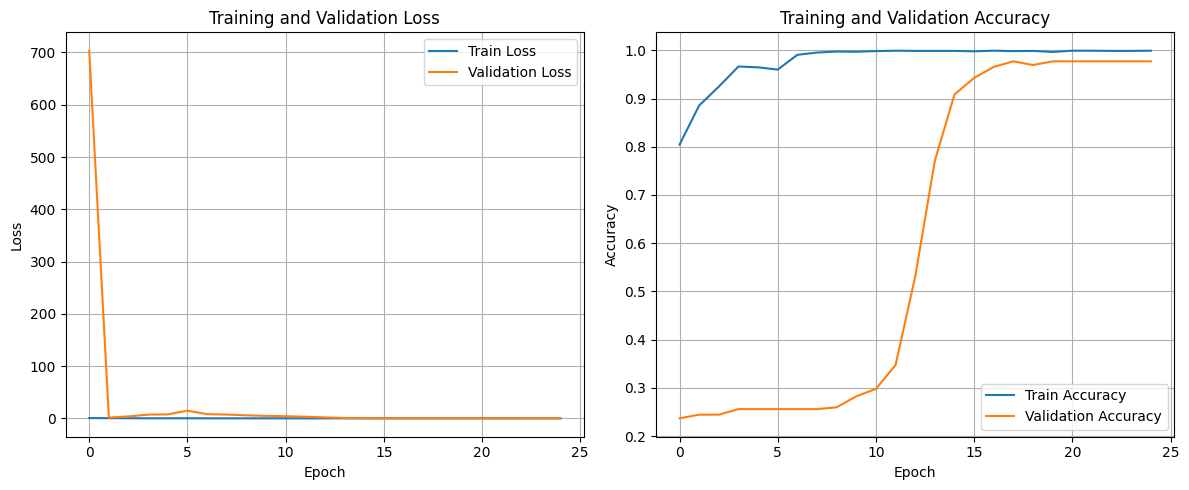

In [ ]:
# Evaluation
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 602ms/step
Test Accuracy: 0.9801
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.99      0.98      0.99       165
        no_tumor       0.97      1.00      0.98       158
meningioma_tumor       0.97      0.96      0.96       164
 pituitary_tumor       0.99      0.98      0.98       166

        accuracy                           0.98       653
       macro avg       0.98      0.98      0.98       653
    weighted avg       0.98      0.98      0.98       653



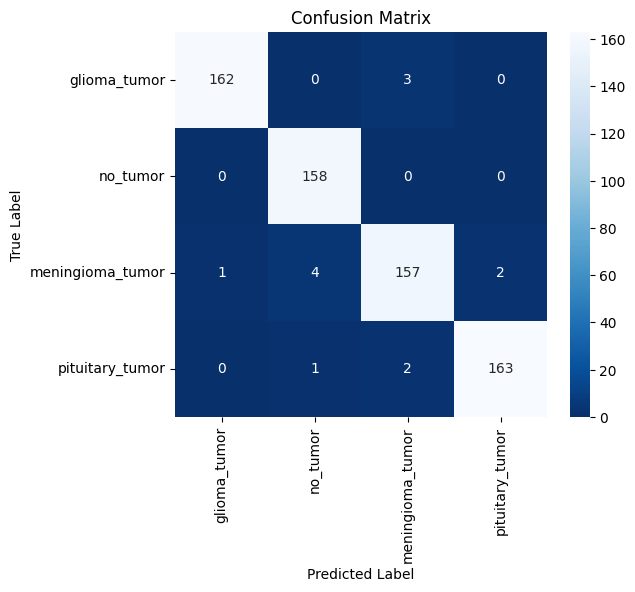

In [ ]:
# Model predictions on the test data
y_pred_test = model.predict(X_test)

# Converting predictions and true values from One-Hot to numerical class
y_pred_test_labels = np.argmax(y_pred_test, axis=1)
y_true_test_labels = np.argmax(y_test, axis=1)

# Calculating the model accuracy on the test data
accuracy = accuracy_score(y_true_test_labels, y_pred_test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_true_test_labels, y_pred_test_labels, target_names=labels))

# Confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true_test_labels, y_pred_test_labels), annot=True, fmt='d', cmap='Blues_r',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# CNN Model

In [ ]:
# Create a proper input layer and CNN model
num_classes=4

# Input layer
input_layer = Input(shape=(image_size, image_size, 3))

# First Convolutional Block
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

# Second Convolutional Block
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

# Third Convolutional Block
x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

# Fourth Convolutional Block
x = Conv2D(256, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

# Fifth Convolutional Block
x = Conv2D(512, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

# Flatten and Dense Layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=x)

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 512)                 │           2,0

 Total params: 8,262,084 (31.52 MB)

 Trainable params: 8,258,564 (31.50 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [ ]:
# Tensorboard callback for logging training metrics
tensorboard = TensorBoard(log_dir='ModelLogs')

# Modelcheckpoint callback to save the best model
checkpoint = ModelCheckpoint("Model.keras", monitor="val_accuracy",
                             save_best_only=True, verbose=1)

# ReduceLROnPlateau callback to reduce learning rate if validation accuracy plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2,
                              min_delta=0.0001, verbose=1)

In [9]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =25, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5704 - loss: 1.2428
Epoch 1: val_accuracy improved from -inf to 0.25573, saving model to Model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 506s 7s/step - accuracy: 0.5716 - loss: 1.2390 - val_accuracy: 0.2557 - val_loss: 5.8017 - learning_rate: 5.0000e-04
Epoch 2/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7794 - loss: 0.5995
Epoch 2: val_accuracy improved from 0.25573 to 0.29771, saving model to Model.keras
74/74 ━━━━━━━━━━━━━━━━━━━━ 500s 7s/step - accuracy: 0.7793 - loss: 0.6000 - val_accuracy: 0.2977 - val_loss: 3.1086 - learning_rate: 5.0000e-04
Epoch 3/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8001 - loss: 0.5679
Epoch 3: val_accuracy did not improve from 0.29771
74/74 ━━━━━━━━━━━━━━━━━━━━ 495s 7s/step - accuracy: 0.8001 - loss: 0.5675 - val_accuracy: 0.2939 - val_loss: 2.9272 - learning_rate: 5.0000e-04
Epoch 4/25
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8350 - loss: 0.4358
Epoch 4: val_accurac

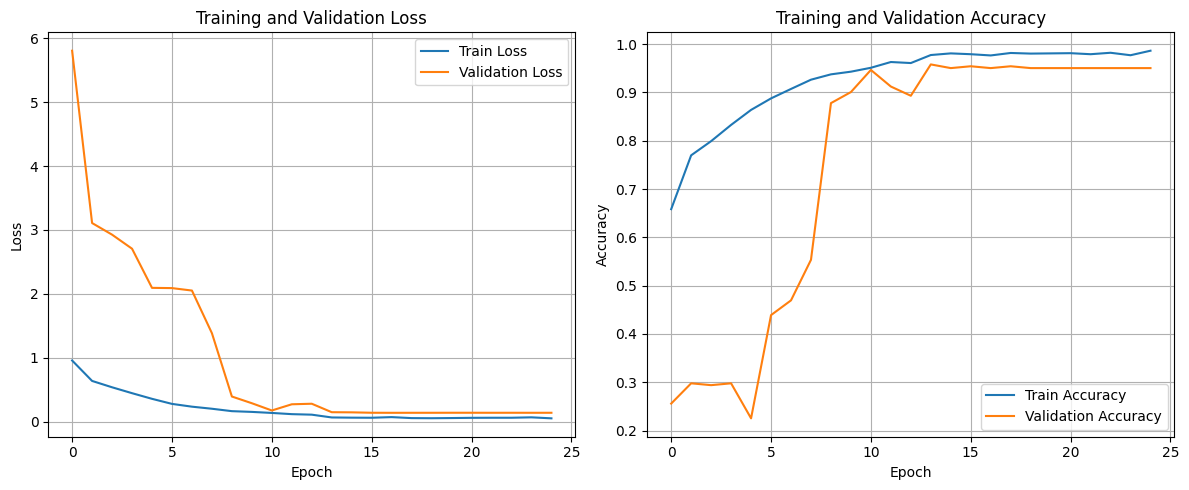

In [12]:
# Evaluation
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
Test Accuracy: 0.9525
Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.93      0.95       165
        no_tumor       0.98      0.97      0.98       158
meningioma_tumor       0.89      0.93      0.91       164
 pituitary_tumor       0.98      0.98      0.98       166

        accuracy                           0.95       653
       macro avg       0.95      0.95      0.95       653
    weighted avg       0.95      0.95      0.95       653



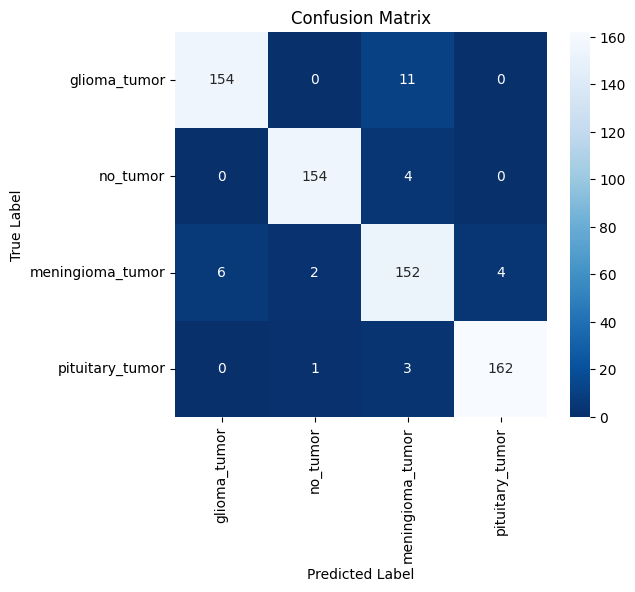

In [13]:
# Model predictions on the test data
y_pred_test = model.predict(X_test)

# Converting predictions and true values from One-Hot to numerical class
y_pred_test_labels = np.argmax(y_pred_test, axis=1)
y_true_test_labels = np.argmax(y_test, axis=1)

# Calculating the model accuracy on the test data
accuracy = accuracy_score(y_true_test_labels, y_pred_test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_true_test_labels, y_pred_test_labels, target_names=labels))

# Confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true_test_labels, y_pred_test_labels), annot=True, fmt='d', cmap='Blues_r',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
